In [82]:
!pip install -U timm

In [83]:
!pip install pytorch_lightning

In [3]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/kvasir-dataset-v2.zip" -d "/content/drive/MyDrive/Colab Notebooks/"

In [112]:
!pip install torchsummary

In [ ]:
# https://github.com/huggingface/pytorch-image-models/issues/1816

In [115]:
from torch import nn
import timm, torch, cv2
import numpy as np
import pytorch_lightning as pl
# from box import Box
import albumentations, numpy as np
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import os, warnings
from tqdm import tqdm
import pickle
from albumentations.pytorch import ToTensorV2
warnings.filterwarnings('ignore')
dataset_dir= "/kaggle/input/kvasir-gi-image-classification/kvasir-dataset-v2"
seed=2023
image_size=384

In [116]:
#### Image Load for data and preprocess for model
class AlbumentationTransform():
    def __init__(self, albumentations_transform):
        self.albumentations_transform=albumentations_transform

    def __call__(self, sample):
        image = np.array(sample)
        transformed =self.albumentations_transform(image=image)
        transformed_image= transformed['image']
        return transformed_image

image_size = 384
transforms_train = albumentations.Compose([
    albumentations.Resize(height=image_size, width=image_size, interpolation=cv2.INTER_LINEAR),
    albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.5, interpolation=cv2.INTER_LINEAR),
    albumentations.HorizontalFlip(p=0.5), #Flips the image horizontally (left to right) with a probability of 50%
    albumentations.VerticalFlip(p=0.5), #Flips the image vertically (top to bottom) with a probability of 50%
    albumentations.Transpose(p=0.5), #Transposes the image (flips it along the diagonal)
    albumentations.RandomBrightness(limit=0.1, p=0.7),#Randomly adjusts the brightness of the image by up to 10%
    albumentations.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=10, p=0.5), #randomly shifts, scales, and rotates the image
    albumentations.RandomBrightnessContrast(0.1, 0.1, p=0.5), #Randomly adjusts both brightness and contrast of the image
    albumentations.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),#Randomly shifts the red, green, and blue color channels of the image##
    albumentations.OneOf([
    albumentations.OpticalDistortion(distort_limit=1.),#this is a choice between two distortion techniques, both with a 0.5 probability
    albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.5),
    albumentations.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

dataset = ImageFolder(dataset_dir, transform =AlbumentationTransform(transforms_train))

In [ ]:
# if isinstance(module, torch.nn.BatchNorm2d)
# if hasattr(module, "qconfig")

In [105]:
class MyLightningModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model(
            'fastvit_t8',
            in_chans=3,
            features_only=False,
            pretrained=False,
            num_classes=8,
        )
        self.model.head = torch.nn.Sequential(
        torch.nn.AdaptiveAvgPool2d(1),
        torch.nn.Flatten(),
        torch.nn.Identity()
    )
    def forward(self, x):
        x = self.model(x)
        return x

# Create an instance of your model
model= MyLightningModule()

In [117]:
from torchsummary import summary
summary(model, input_size=(3, 338, 338))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 169, 169]             144
          Identity-2         [-1, 48, 169, 169]               0
          Identity-3         [-1, 48, 169, 169]               0
    BatchNormAct2d-4         [-1, 48, 169, 169]              96
       ConvNormAct-5         [-1, 48, 169, 169]               0
            Conv2d-6         [-1, 48, 169, 169]           1,296
          Identity-7         [-1, 48, 169, 169]               0
          Identity-8         [-1, 48, 169, 169]               0
    BatchNormAct2d-9         [-1, 48, 169, 169]              96
      ConvNormAct-10         [-1, 48, 169, 169]               0
         Identity-11         [-1, 48, 169, 169]               0
             GELU-12         [-1, 48, 169, 169]               0
   MobileOneBlock-13         [-1, 48, 169, 169]               0
           Conv2d-14           [-1, 48,

In [118]:
model

MyLightningModule(
  (model): FastVit(
    (stem): Sequential(
      (0): MobileOneBlock(
        (se): Identity()
        (conv_kxk): ModuleList(
          (0): ConvNormAct(
            (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
          )
        )
        (conv_scale): ConvNormAct(
          (conv): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (bn): BatchNormAct2d(
            48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
        )
        (act): GELU(approximate='none')
      )
      (1): MobileOneBlock(
        (se): Identity()
        (conv_kxk): ModuleList(
          (0): ConvNormAct(
            (conv): Conv2d(48, 48, kernel_si

In [119]:
model = model.load_from_checkpoint('/kaggle/input/pytorch-lighting-model-build-up/weights/FastVit_T8_epoch=26_valid_loss_epoch=0.22_valid_acc_epoch=0.93.ckpt',map_location=torch.device('cpu'), strict=False)

In [120]:
features = model(torch.randn(1, 3, 384, 384))
features.shape

torch.Size([1, 768])

In [121]:
features=[]
labels=[]
with torch.no_grad():
    for inputs, label in tqdm(dataset, desc="Extracting features"):
        img = (inputs).unsqueeze(0)
        output=model(img)
        features.append(output)
        labels.append(dataset.classes[label])
    embedding=torch.cat(features)

Extracting features: 100%|██████████| 8000/8000 [25:34<00:00,  5.21it/s]


In [122]:
embedding.shape

torch.Size([8000, 768])

In [124]:
output_file = "fastVit_T8_features.pkl"
data_dict = {
    "features": embedding,
    "labels": labels
}
with open(output_file, 'wb') as f:
    pickle.dump(data_dict, f)

In [ ]:
# f = features.view(features.shape[0], -1, features.shape[2], features.shape[3])
# d=features.view(features.shape[0], -1)  #for input

#### Modeling

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix
sc=StandardScaler()
Le=LabelEncoder()

In [54]:
with open("/kaggle/input/kvasirdataset/fastVit_T8_features.pkl", "rb") as f:
    data_dict  = pickle.load(f)

In [55]:
feat_emb = data_dict["features"]
classes = data_dict["labels"]

In [56]:
#number of classes 
len(classes)

8000

In [57]:
#number of valus of each class
len(feat_emb[0])

768

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    feat_emb, classes, test_size=0.2, random_state=42
)

In [59]:
#Label Encoder and Standardsclaeization
def standararization_encoder(X_train,X_test,y_train, y_test):
    """ first come standarrization and then Label encoder"""
    X1=sc.fit_transform(X_train)
    X2=sc.fit_transform(X_test)
    y1=Le.fit_transform(y_train)
    y2=Le.fit_transform(y_test)
    return X1, X2, y1, y2

In [60]:
X1,X2, y1, y2=standararization_encoder(X_train,X_test,y_train, y_test)

In [61]:
# model calling Helper
def prediction_helper(model_name, X_train, y_train, X_test, y_test):
    model_name.fit(X_train,y_train)
    y_pred=model_name.predict(X_test)
    acc=accuracy_score(y_pred, y_test)
    return acc

#### SVM

In [62]:
svc = SVC(C=1.0, probability=True)
svc_acc=prediction_helper(svc, X1, y_train,X2, y_test)
svc_acc

0.846875

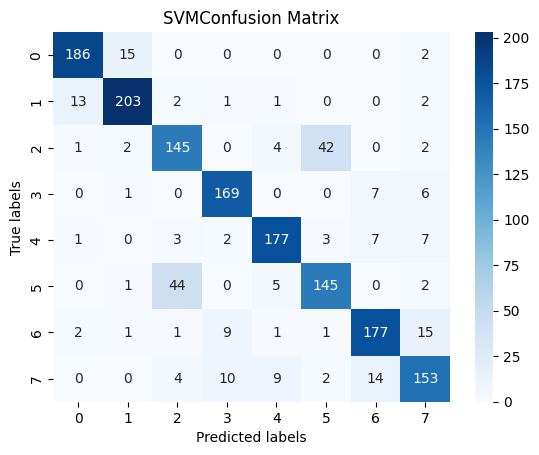

In [63]:
svc.fit(X1,y_train)
y_pred=svc.predict(X2)
cm_xgb = confusion_matrix(y_test,  y_pred)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='d')
plt.title('SVMConfusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

####  KNN Classification


In [64]:
knn = KNeighborsClassifier(n_neighbors=15)
knn_acc=prediction_helper(knn, X1, y_train,X2, y_test)
knn_acc

0.8025

#### Random Forest

In [65]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
# Train the model
rf_acc=prediction_helper(rf, X_train, y_train,X_test, y_test)
rf_acc

0.805625

#### Adaboost

In [66]:
from sklearn.tree import DecisionTreeClassifier
DTC=DecisionTreeClassifier(max_depth=2)
Ada = AdaBoostClassifier(n_estimators=20, base_estimator=DTC ,learning_rate=0.01)
ada_acc=prediction_helper(Ada, X1, y_train,X2, y_test)
ada_acc

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.584375

#### LGBM

In [67]:
lgb_params = {
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    'device' : 'cpu',
}
lgb_1 = lgb.LGBMClassifier(**lgb_params)
lgb_1.fit(X_train, y_train,
          eval_set=[(X_test,y_test)])

[1]	valid_0's multi_logloss: 1.7093
[2]	valid_0's multi_logloss: 1.49205
[3]	valid_0's multi_logloss: 1.33636
[4]	valid_0's multi_logloss: 1.21382
[5]	valid_0's multi_logloss: 1.11667
[6]	valid_0's multi_logloss: 1.0364
[7]	valid_0's multi_logloss: 0.9697
[8]	valid_0's multi_logloss: 0.915977
[9]	valid_0's multi_logloss: 0.867521
[10]	valid_0's multi_logloss: 0.829108
[11]	valid_0's multi_logloss: 0.793913
[12]	valid_0's multi_logloss: 0.765086
[13]	valid_0's multi_logloss: 0.740609
[14]	valid_0's multi_logloss: 0.717079
[15]	valid_0's multi_logloss: 0.697439
[16]	valid_0's multi_logloss: 0.678953
[17]	valid_0's multi_logloss: 0.66393
[18]	valid_0's multi_logloss: 0.648743
[19]	valid_0's multi_logloss: 0.635193
[20]	valid_0's multi_logloss: 0.622929
[21]	valid_0's multi_logloss: 0.61385
[22]	valid_0's multi_logloss: 0.604827
[23]	valid_0's multi_logloss: 0.595492
[24]	valid_0's multi_logloss: 0.587971
[25]	valid_0's multi_logloss: 0.581109
[26]	valid_0's multi_logloss: 0.574384
[27]	va

LGBMClassifier(device='cpu', metric='multi_logloss', objective='multiclass')

In [68]:
preds_valid = lgb_1.predict(X_test)
lg_acc = accuracy_score(y_test,  preds_valid)
lg_acc

0.826875

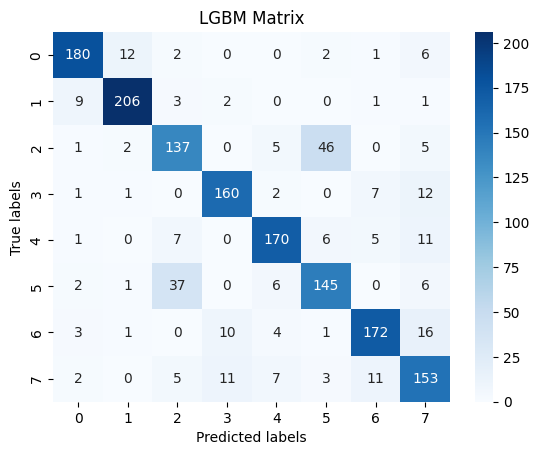

In [69]:
cm_xgb = confusion_matrix(y_test,  preds_valid)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='d')
plt.title('LGBM Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

#### XGB

In [70]:
# declare parameters
params = {
            'objective' : 'multi:softmax',
            'tree_method': 'hist',
            'eval_metric': 'mlogloss',
            'n_estimators':300,
            'predictor': 'cpu_predictor'
        }       
xgb_1 = xgb.XGBClassifier(**params)
xgb_1.fit(X_train, y1,
          early_stopping_rounds=200,
          eval_set=[(X_test,y2)],
          verbose=True)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.48828
[1]	validation_0-mlogloss:1.23295
[2]	validation_0-mlogloss:1.07248
[3]	validation_0-mlogloss:0.95644
[4]	validation_0-mlogloss:0.87356
[5]	validation_0-mlogloss:0.80515
[6]	validation_0-mlogloss:0.75404
[7]	validation_0-mlogloss:0.71345
[8]	validation_0-mlogloss:0.67966
[9]	validation_0-mlogloss:0.65261
[10]	validation_0-mlogloss:0.63226
[11]	validation_0-mlogloss:0.61446
[12]	validation_0-mlogloss:0.59930
[13]	validation_0-mlogloss:0.58840
[14]	validation_0-mlogloss:0.57739
[15]	validation_0-mlogloss:0.56924
[16]	validation_0-mlogloss:0.56263
[17]	validation_0-mlogloss:0.55731
[18]	validation_0-mlogloss:0.55102
[19]	validation_0-mlogloss:0.54628
[20]	validation_0-mlogloss:0.54024
[21]	validation_0-mlogloss:0.53892
[22]	validation_0-mlogloss:0.53681
[23]	validation_0-mlogloss:0.53442
[24]	validation_0-mlogloss:0.53407
[25]	validation_0-mlogloss:0.53255
[26]	validation_0-mlogloss:0.53170
[27]	validation_0-mlogloss:0.53013
[28]	validation_0-mlogloss:0.5

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax',
              predictor='cpu_predictor', ...)

In [71]:
preds=xgb_1.predict(X_test)
xg_acc=accuracy_score(y2, preds)
xg_acc

0.82

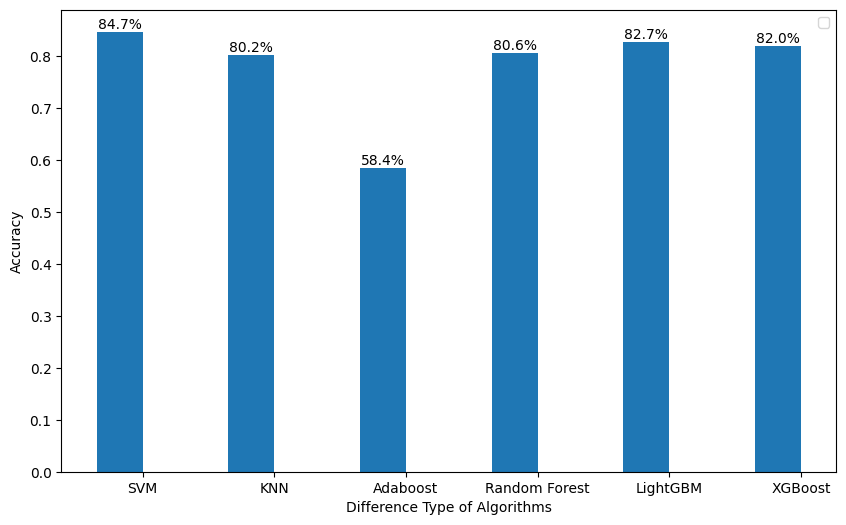

In [72]:
#### Result of all algorithm
# Algorithms to compare
algorithms = [ 'SVM', 'KNN', 'Adaboost','Random Forest','LightGBM','XGBoost']

# mlp_score xg_score ada_score dt_score svr_score knn_score lr_score
acc =[svc_acc, knn_acc, ada_acc, rf_acc, lg_acc, xg_acc]

# Bar plot comparing precision with and without smoothing
plt.figure(figsize=(10, 6))
width = 0.35
bars1 = plt.bar(np.arange(len(algorithms)), acc, width)
plt.xticks(np.arange(len(algorithms)) + width / 2, algorithms)
plt.xlabel('Difference Type of Algorithms')
plt.ylabel('Accuracy')


# Add percentage values on top of each bar
for bar in bars1:
    height1 = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height1, f'{height1:.1%}', ha='center', va='bottom')

plt.legend()
plt.show()

#### Difference Type of Clustering

In [40]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
kmeans=KMeans(init='k-means++',n_clusters=8, n_init=57, max_iter=1800,random_state =42)
ms = MinMaxScaler()
X1 = ms.fit_transform(feat_emb)

In [146]:
# label_names = dataset.classes
# label_dict = {label_num: label_name for label_num, label_name in enumerate(label_names)}
# label_names = [label_dict[label] for label in kmeans.labels_]

#### PCA with K-Means

383


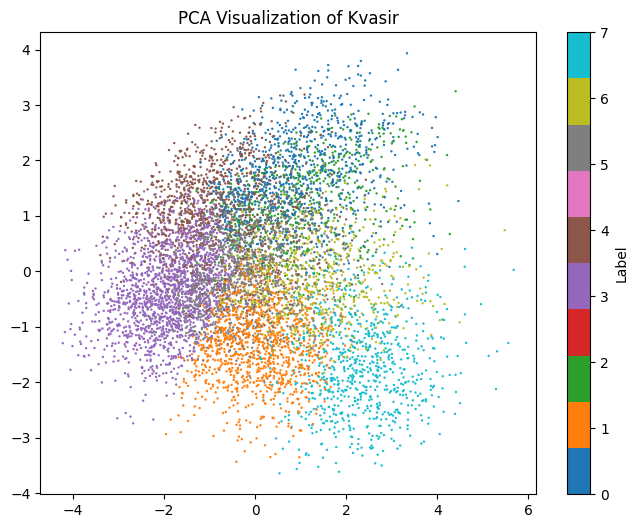

CPU times: user 48.2 s, sys: 12.7 s, total: 1min
Wall time: 20.1 s


In [147]:
%%time
pca= PCA(.98)
pca.fit(X1)
print(pca.n_components_)
X_pca = pca.transform(X1)
kmeans.fit(X_pca)
# Visualize the t-SNE representation
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='tab10', s = 0.5)
plt.colorbar(label='Label')
plt.title('PCA Visualization of Kvasir')
plt.show()

#### SVD with K-Means

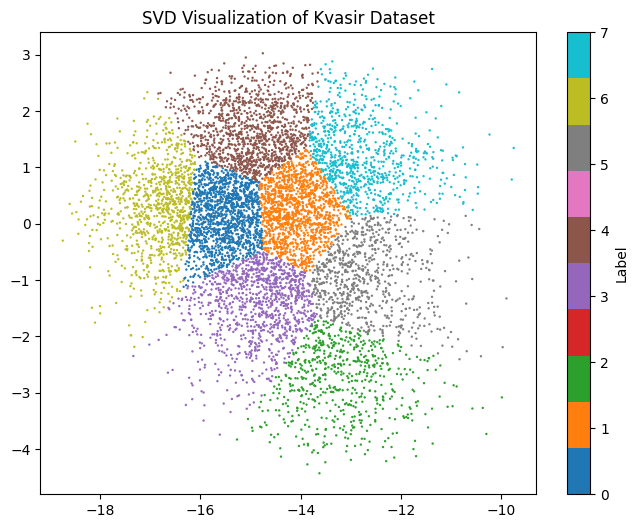

CPU times: user 12.1 s, sys: 5.84 s, total: 17.9 s
Wall time: 5.2 s


In [148]:
%%time
U, s, V = np.linalg.svd(X1, full_matrices=False)
n_components = 2
X_svd = U[:, :n_components] * s[:n_components]
kmeans.fit(X_svd)
# Visualize the t-SNE representation
plt.figure(figsize=(8, 6))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=kmeans.labels_, cmap='tab10', s = 0.5)
plt.colorbar(label='Label')
plt.title('SVD Visualization of Kvasir Dataset')
plt.show()

#### K-Means with t-SNE

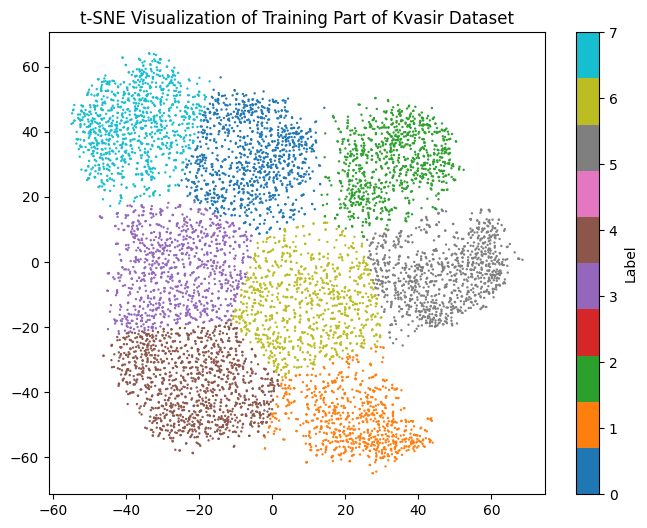

CPU times: user 1min 50s, sys: 545 ms, total: 1min 50s
Wall time: 55.5 s


In [149]:
%%time
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X1)
kmeans.fit(X_tsne)
# Visualize the t-SNE representation
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='tab10', s = 0.5)
plt.colorbar(label='Label')
plt.title('t-SNE Visualization of Training Part of Kvasir Dataset')
plt.show()

#### Concatenation Both Features

In [11]:
import pickle
with open("/kaggle/input/kvasirdataset/datasets_kvasir_rifat_mobileOne_s4_2048.pkl", "rb") as f:
         mobileone_s4  = pickle.load(f)

In [12]:
mobile_s4=mobileone_s4["features"]
target_s4=mobileone_s4['labels']

In [13]:
mobile_s4.shape

(8000, 2048)

In [14]:
import pickle
with open("/kaggle/input/kvasirdataset/efficientvitv1_m3_features.pkl", "rb") as f:
         efficientvit_m3  = pickle.load(f)

In [15]:
efficientvit=efficientvit_m3["features"]
target_m3=efficientvit_m3['labels']
efficientvit.shape

torch.Size([8000, 320])

In [41]:
# 320+768+2048

3136

In [18]:
combined_features=np.concatenate((mobile_s4, efficientvit,feat_emb), axis=1)
labels = data_dict['labels']

In [19]:
combined_features.shape

(8000, 3136)

In [20]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    combined_features, labels, test_size=0.2, random_state=42
)

In [21]:
Xc1,Xc2, yc1, yc2=standararization_encoder(Xc_train, Xc_test, yc_train, yc_test)

In [22]:
#SVM
svc = SVC(C=1.0, probability=True)
svc_accc=prediction_helper(svc, Xc1, yc_train,Xc2, yc_test)
svc_accc

0.99

In [23]:
#KNN
knn = KNeighborsClassifier(n_neighbors=15)
knn_accc=prediction_helper(knn, Xc1, yc_train,Xc2, yc_test)
knn_accc

0.988125

In [24]:
#Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_accc=prediction_helper(rf, Xc_train, yc_train,Xc_test, yc_test)
rf_accc

0.998125

In [38]:
#decisionTree
DTC=DecisionTreeClassifier(max_depth=2)
Ada = AdaBoostClassifier(n_estimators=20, base_estimator=DTC ,learning_rate=0.01)
ada_accc=prediction_helper(Ada, Xc_train, yc_train,Xc_test, yc_test)
ada_accc

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.99375

In [26]:
# LGBM
lgb_params = {
    'objective' : 'multiclass',
    'metric' : 'multi_logloss',
    'device' : 'cpu',
}
lgbm_2 = lgb.LGBMClassifier(**lgb_params)
lgbm_2.fit(Xc_train, yc_train,
          eval_set=[(Xc_test,yc_test)])

[1]	valid_0's multi_logloss: 1.43985
[2]	valid_0's multi_logloss: 1.11451
[3]	valid_0's multi_logloss: 0.89297
[4]	valid_0's multi_logloss: 0.728783
[5]	valid_0's multi_logloss: 0.601024
[6]	valid_0's multi_logloss: 0.499542
[7]	valid_0's multi_logloss: 0.417988
[8]	valid_0's multi_logloss: 0.351129
[9]	valid_0's multi_logloss: 0.296405
[10]	valid_0's multi_logloss: 0.250806
[11]	valid_0's multi_logloss: 0.212935
[12]	valid_0's multi_logloss: 0.181536
[13]	valid_0's multi_logloss: 0.154965
[14]	valid_0's multi_logloss: 0.132906
[15]	valid_0's multi_logloss: 0.113958
[16]	valid_0's multi_logloss: 0.098146
[17]	valid_0's multi_logloss: 0.0848977
[18]	valid_0's multi_logloss: 0.0734339
[19]	valid_0's multi_logloss: 0.0638714
[20]	valid_0's multi_logloss: 0.0559433
[21]	valid_0's multi_logloss: 0.0492707
[22]	valid_0's multi_logloss: 0.0434937
[23]	valid_0's multi_logloss: 0.0386993
[24]	valid_0's multi_logloss: 0.0344442
[25]	valid_0's multi_logloss: 0.0310431
[26]	valid_0's multi_logloss

LGBMClassifier(device='cpu', metric='multi_logloss', objective='multiclass')

In [27]:
preds_valid = lgbm_2.predict(Xc_test)
lg_accc = accuracy_score(yc_test,  preds_valid)
lg_accc

0.995625

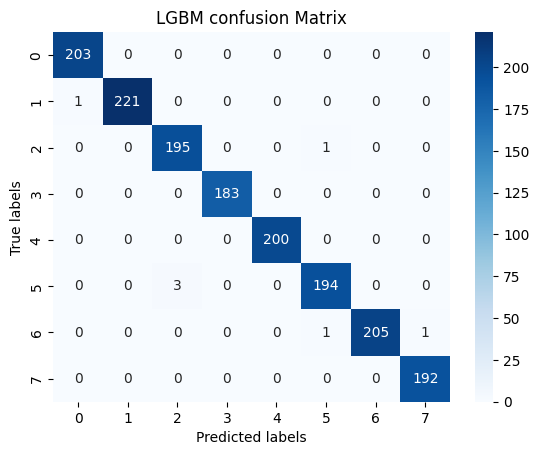

In [30]:
cm_xgb = confusion_matrix(yc_test,  preds_valid)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='d')
plt.title('LGBM confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [31]:
# XGBoost
params = {
            'objective' : 'multi:softmax',
            'tree_method': 'hist',
            'eval_metric': 'mlogloss',
            'n_estimators':300,
            'predictor': 'cpu_predictor'
        }       
xg_2 = xgb.XGBClassifier(**params)
xg_2.fit(Xc_train, yc1,
          early_stopping_rounds=10,
          eval_set=[(Xc_test,yc2)],
          verbose=True)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.04879
[1]	validation_0-mlogloss:0.71776
[2]	validation_0-mlogloss:0.51396
[3]	validation_0-mlogloss:0.37653
[4]	validation_0-mlogloss:0.28041
[5]	validation_0-mlogloss:0.21093
[6]	validation_0-mlogloss:0.16068
[7]	validation_0-mlogloss:0.12397
[8]	validation_0-mlogloss:0.09676
[9]	validation_0-mlogloss:0.07586
[10]	validation_0-mlogloss:0.06078
[11]	validation_0-mlogloss:0.04935
[12]	validation_0-mlogloss:0.04095
[13]	validation_0-mlogloss:0.03479
[14]	validation_0-mlogloss:0.02982
[15]	validation_0-mlogloss:0.02630
[16]	validation_0-mlogloss:0.02372
[17]	validation_0-mlogloss:0.02162
[18]	validation_0-mlogloss:0.02019
[19]	validation_0-mlogloss:0.01881
[20]	validation_0-mlogloss:0.01776
[21]	validation_0-mlogloss:0.01723
[22]	validation_0-mlogloss:0.01649
[23]	validation_0-mlogloss:0.01619
[24]	validation_0-mlogloss:0.01567
[25]	validation_0-mlogloss:0.01543
[26]	validation_0-mlogloss:0.01516
[27]	validation_0-mlogloss:0.01500
[28]	validation_0-mlogloss:0.0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax',
              predictor='cpu_predictor', ...)

In [33]:
preds=xg_2.predict(Xc_test)
xg_accc=accuracy_score(yc2, preds)
xg_accc

0.99625

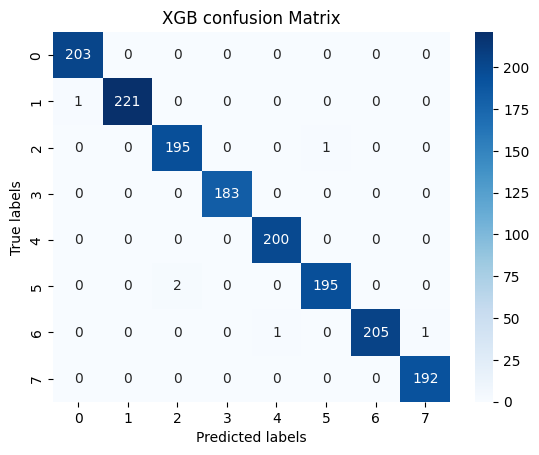

In [36]:
cm_xgb = confusion_matrix(yc2,  preds)
sns.heatmap(cm_xgb, annot=True, cmap='Blues', fmt='d')
plt.title('XGB confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

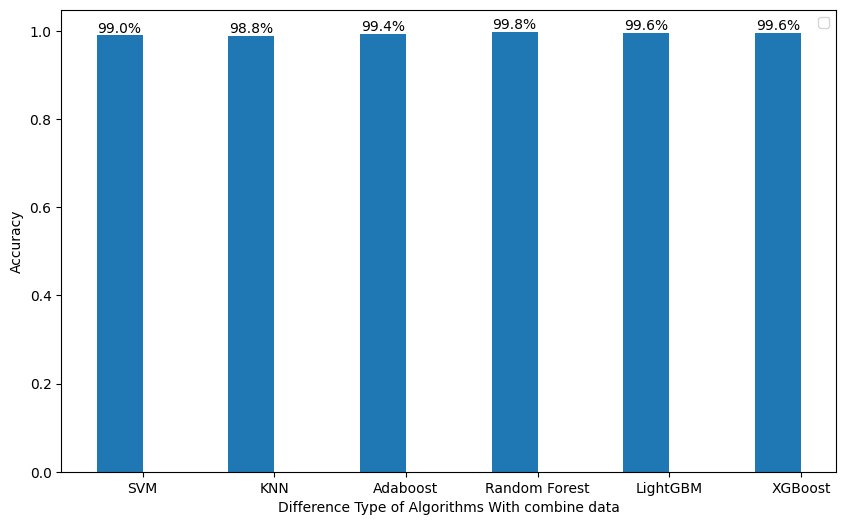

In [37]:
#### Result of all algorithm
# Algorithms to compare
algorithms = [ 'SVM', 'KNN', 'Adaboost','Random Forest','LightGBM','XGBoost']

# mlp_score xg_score ada_score dt_score svr_score knn_score lr_score
acc =[svc_accc, knn_accc, ada_accc, rf_accc, lg_accc, xg_accc]

# Bar plot comparing precision with and without smoothing
plt.figure(figsize=(10, 6))
width = 0.35
bars1 = plt.bar(np.arange(len(algorithms)), acc, width)
plt.xticks(np.arange(len(algorithms)) + width / 2, algorithms)
plt.xlabel('Difference Type of Algorithms With combine data')
plt.ylabel('Accuracy')


# Add percentage values on top of each bar
for bar in bars1:
    height1 = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height1, f'{height1:.1%}', ha='center', va='bottom')

plt.legend()
plt.show()

#### Clustering

In [42]:
# kmeans=KMeans(init='k-means++',n_clusters=8, n_init=57, max_iter=1800,random_state =42)
# ms = MinMaxScaler()
input_data = ms.fit_transform(combined_features)

726


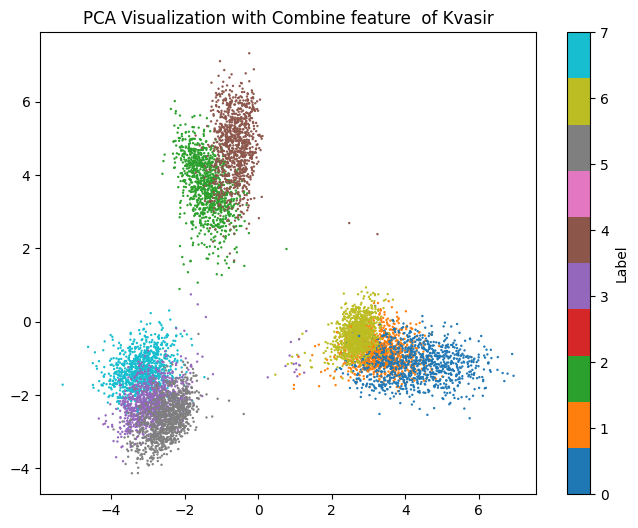

CPU times: user 1min 50s, sys: 41.5 s, total: 2min 31s
Wall time: 45.4 s


In [43]:
%%time
pca= PCA(.98)
pca.fit(input_data)
print(pca.n_components_)
X_pca = pca.transform(input_data)
kmeans.fit(X_pca)
# Visualize the t-SNE representation
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='tab10', s = 0.5)
plt.colorbar(label='Label')
plt.title('PCA Visualization with Combine feature  of Kvasir')
plt.show()

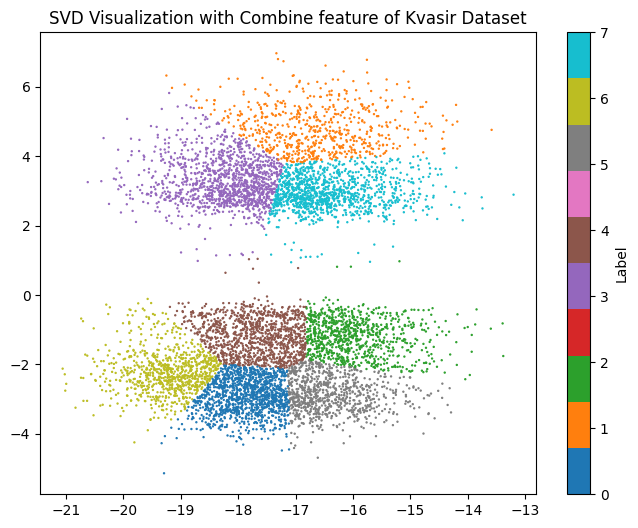

CPU times: user 1min 51s, sys: 12.5 s, total: 2min 4s
Wall time: 34.6 s


In [44]:
%%time
U, s, V = np.linalg.svd(input_data, full_matrices=False)
n_components = 2
X_svd = U[:, :n_components] * s[:n_components]
kmeans.fit(X_svd)
# Visualize the t-SNE representation
plt.figure(figsize=(8, 6))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=kmeans.labels_, cmap='tab10', s = 0.5)
plt.colorbar(label='Label')
plt.title('SVD Visualization with Combine feature of Kvasir Dataset')
plt.show()

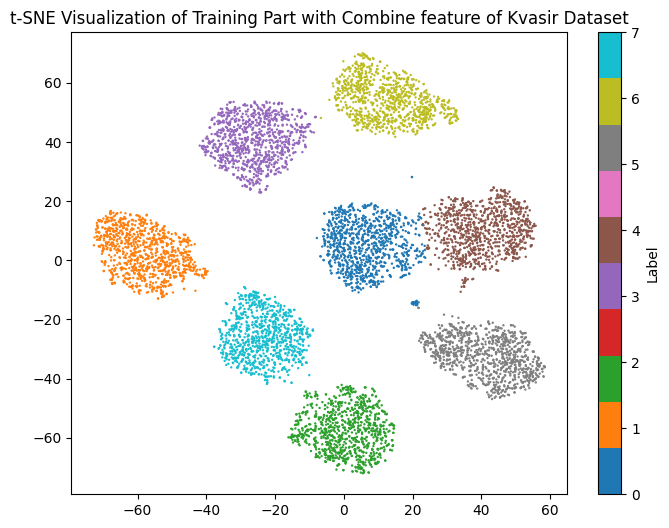

CPU times: user 1min 34s, sys: 1.82 s, total: 1min 36s
Wall time: 1min 32s


In [47]:
%%time
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(input_data)
kmeans.fit(X_tsne)
# Visualize the t-SNE representation
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='tab10', s = 0.5)
plt.colorbar(label='Label')
plt.title('t-SNE Visualization of Training Part with Combine feature of Kvasir Dataset')
plt.show()

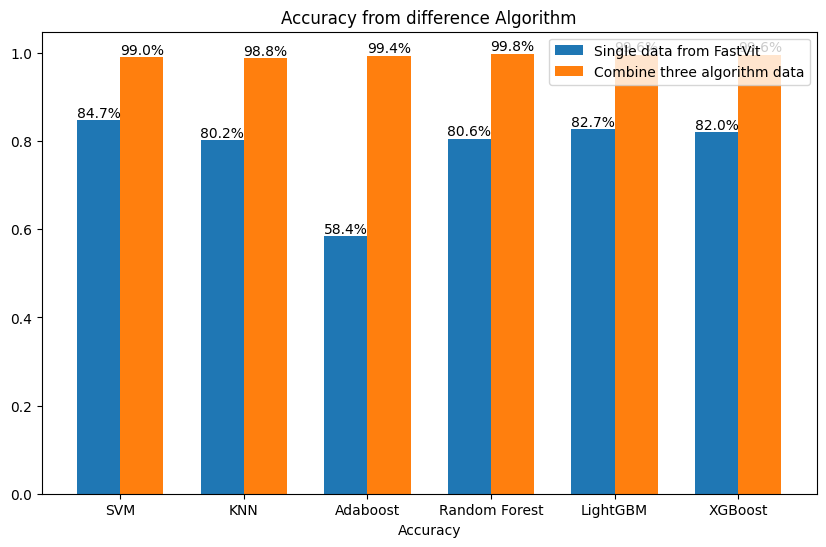

In [73]:
# Algorithms to compare
algorithms = [ 'SVM', 'KNN', 'Adaboost','Random Forest','LightGBM','XGBoost']

feature_en =[svc_acc, knn_acc, ada_acc, rf_acc, lg_acc, xg_acc]

# Calculate metrics for each algorithm with smoothing
remove_outliers =[svc_accc, knn_accc, ada_accc, rf_accc, lg_accc, xg_accc]

# Bar plot comparing precision with and without smoothing
plt.figure(figsize=(10, 6))
width = 0.35
bars1 = plt.bar(np.arange(len(algorithms)), feature_en, width, label='Single data from FastVit')
bars2 = plt.bar(np.arange(len(algorithms)) + width, remove_outliers, width, label='Combine three algorithm data')
plt.xticks(np.arange(len(algorithms)) + width / 2, algorithms)
plt.xlabel('Accuracy')
# plt.ylabel('Precision')
plt.title('Accuracy from difference Algorithm')

# Add percentage values on top of each bar
for bar1, bar2 in zip(bars1, bars2):
    height1 = bar1.get_height()
    height2 = bar2.get_height()
    plt.text(bar1.get_x() + bar1.get_width() / 2, height1, f'{height1:.1%}', ha='center', va='bottom')
    plt.text(bar2.get_x() + bar2.get_width() / 2, height2, f'{height2:.1%}', ha='center', va='bottom')

plt.legend()
plt.show()

##### Working Flow

This task is related to task-11 where I create a model from fastVit using Kvasir dataset dataset. In this task also apply classification but difference way like just extract those feature using that fastVit model with previous model best weight and apply several machine learning algorithm with this feature.

#### Dataset
Autometic detection on diseases by use computer is an important but still unexplored on reaserch. Human digestive system may be affected several diseases like esophageal, stomach and colerectal cancer amccounts for 2.8 million new casses and 1.8 million deaths every year.Kvasir a dataset containing image from inside the gastrointesnial(GI) track. Collection of image are classifies into three important anatomical landmarks and three clinically significant with two image of related endoscopic polyp removal. There is total 8000 images and each class contain 1000 images.The dataset consist image with difference resolution from 720x576 to 1920x1072 pixels and organized with separate folder name accordingly.

Using this dataset create a feature extraction dataset using FastVit. Just a query in the Fastvit model improvised the classification layer with sequntial layer and the output of each image will be 768 instead of 8 that means instead of using classification values take feature for 8000 images and make a pickle file.

#### EDA
As mentioned in dataset is a multiclass classification with medical images. Check basic notes like size, shape, pixel contribution, color contribution and view each images from each class. Count the shape from each resolution and got there is 5137 images from  576x720 resolution and 2122 images from 1024x1280 resolution and every images from 3 channel. Then try to find the inerpolation are of images by doing crop, rotation, flip,resiging, transpose and so on.


#### Pytorch Lighting
PyTorch is extremely easy to use to build complex AI models. But once the research gets complicated and things like multi-GPU training, 16-bit precision and TPU training get mixed in, users are likely to introduce bugs. Pytorch Lighting solves exactly this issue and lighting struture pytorch code so it can details and abstract on training.Basically it was created proffesional researcher and PHD students for working with AI research.

#### Data Preparation and Model Build
FastVit paper is a recent paper from transformer and its gained SOTA result on several sector with ImageNet-1k dataset. In this paper authors trained their image with 256x256 and find-tuned with 384x384 resolution. So I choose fine-tuned image size for this model which is 384x384. Then differentiate this images with label and data with sub-Image classes. After classified those images with labels as well as divided into three section training, validation, testing size with 5564, 1600, 832 accordingly.In that paper used 1024 batch-size but my computional shortage apply 64 batch-size. Then do difference augmentation on difference part like simple resize and normalizaion apply on testing and validation part and training part applied difference technique from albamentation library. Forgot to mension that here I follow image classification technique from the paper.

Now after that process, This time just create model from timm with `pretrain_weight=False` and `Feature_only=False` then improvised the model head for feature not classification result. In this case just used 768 as output instead of 8. Then apply that model with imageFolder from batch_size=1 and image_size same as mention before. after extracted those feature save as pickle file.

For your information, I just want to mentioned is that I used single model feature extration with SVM,KNN,random Forest, LGBM, XGB and Adaboost also same model applied on combine dataset which extracted from three model.


#### Result and Accuracy: 
Now time to write the result of this injected model on the Kvasir dataset's eatures. This result containing the model accuracy which comes from difference model.This result from single dataset.

| Model| Accuracy |
| ----- | ----- |
|SVM|84.7|
|KNN|80.2|
|Adaboost|58.4|
|Random Forest|80.6|
|LGBM|82.7|
|XGB|82.00|

Lets view the result of combine dataset.

| Model| Accuracy |
| ----- | ----- |
|SVM|99.0|
|KNN|98.8|
|Adaboost|99.4|
|Random Forest|99.8|
|LGBM|99.6|
|XGB|99.6|

#### Conclusion:
Interesting task done, Learn lot of things on this segment and faced some dificulties on extract embedding from VIt model also rearrange the shape an so one. The best model with single data is SVM and with combine data winner model is random forest.
